In [1]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib tk
%autosave 180


%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..") # Adds higher directory to python modules path.
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import torch
import time
import warnings
warnings.filterwarnings("ignore")
from locanmf import LocaNMF
import postprocess

Autosaving every 180 seconds


In [2]:
import os
## [OPTIONAL] if cuda support, uncomment following lines
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# device='cuda'

# else, if on cpu
device='cpu'

# User-defined Parameters

In [3]:
##################################################################################################################
## PARAMETERS THAT YOU SHOULD CHANGE
##################################################################################################################
# Path to data and atlas
mouse_name = 'IJ1'
session_name = 'Mar3'
root_dir = '/media/cat/1TB/yuki/yongxu/locaNMF_data/data/'
data_folder =root_dir+mouse_name+'/'+session_name+'/'
# spatial_data_filename = "IA1_spatial.npy" #
spatial_data_filename =mouse_name+'pm_'+session_name+'_30Hz_code_04_trial_ROItimeCourses_30sec_pca_0.95_spatial.npy'
# temporal_data_filename = "IA1_temporal.npy" # 
temporal_data_filename = mouse_name+'pm_'+session_name+'_30Hz_code_04_trial_ROItimeCourses_30sec_pca_0.95.npy'
# atlas_filename = "maskwarp_1.npy" # contains 'atlas'
random_spatial_data_filename =mouse_name+'pm_'+session_name+'_30Hz_code_04_random_ROItimeCourses_30sec_pca_0.95_spatial.npy'
# temporal_data_filename = "IA1_temporal.npy" # 
random_temporal_data_filename = mouse_name+'pm_'+session_name+'_30Hz_code_04_random_ROItimeCourses_30sec_pca_0.95.npy'

atlas_filename = "atlas_split.npy"

# maxrank = how many max components per brain region. Set maxrank to around 4 for regular dataset.
maxrank = 1
  
# min_pixels = minimum number of pixels in Allen map for it to be considered a brain region
# default min_pixels = 100
min_pixels = 200

# loc_thresh = Localization threshold, i.e. percentage of area restricted to be inside the 'Allen boundary'
# default loc_thresh = 80
loc_thresh = 75

# r2_thresh = Fraction of variance in the data to capture with LocaNMF
# default r2_thresh = 0.99
r2_thresh = 0.96

# Do you want nonnegative temporal components? The data itself should also be nonnegative in this case.
# default nonnegative_temporal = False
nonnegative_temporal = False 

##################################################################################################################
## PARAMETERS THAT YOU SHOULD PROBABLY NOT CHANGE (unless you know what you're doing)
##################################################################################################################
# maxiter_hals = Number of iterations in innermost loop (HALS). Keeping this low provides a sort of regularization.
# default maxiter_hals = 20
maxiter_hals = 20

# maxiter_lambda = Number of iterations for the lambda loop. Keep this high for finding a good solution.
# default maxiter_lambda = 100
maxiter_lambda = 150

# lambda_step = Amount to multiply lambda after every lambda iteration. 
# lambda_init = initial value of lambda. Keep this low. default lambda_init = 0.000001
# lambda_{i+1}=lambda_i*lambda_step. lambda_0=lambda_init. default lambda_step = 1.35
lambda_step = 1.25
lambda_init = 1e-4


In [4]:
# spatial_data_filename.shape
a=np.load(data_folder+spatial_data_filename)
print(a.shape)
b=np.load(data_folder+temporal_data_filename)
print(b.shape)

(7, 16384)
(132, 7, 1801)


# Load & Format Data

In [5]:
spatial = np.load(data_folder+spatial_data_filename)
# spatial_random = np.load(data_folder+random_spatial_data_filename)
# spatial=np.concatenate(spatial_trial,spatial_random,axis=0)
spatial = np.transpose(spatial,[1,0])
denoised_spatial_name = np.reshape(spatial,[128,128,-1])

temporal_trial = np.load(data_folder+temporal_data_filename)
temporal_random = np.load(data_folder+random_temporal_data_filename)
temporal=np.concatenate((temporal_trial,temporal_random),axis=0)
temporal = np.transpose(temporal,[1,0,2])
# denoised_temporal_name = np.reshape(temporal,[-1,42*601])
denoised_temporal_name = np.reshape(temporal,[-1,temporal.shape[1]*temporal.shape[2]])
print('loaded data\n',flush=True)

atlas = np.load('./'+atlas_filename)#['atlas'].astype(float)
#areanames = sio.loadmat(data_folder+atlas_filename)['areanames']

loaded data



In [6]:
# temporal_random.shape

In [7]:
atlas.shape

(128, 128)

In [8]:
plt.imshow(atlas)
# fig=plt.figure(figsize=(20,15))
# for it in np.unique(atlas):
#     plotmap=np.zeros((atlas.shape)); plotmap.fill(np.nan); plotmap[atlas==it]=atlas[atlas==it]
# #     plt.subplot(5,6,it+1)
#     plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); plt.title('Allen region map'); plt.show(); 
#     plt.show()


In [9]:
print(denoised_temporal_name.shape)
print(denoised_spatial_name.shape)
print(atlas.shape)
plt.plot(denoised_temporal_name[:,:601].T); plt.show()

for i in np.arange(7):
    plt.imshow(denoised_spatial_name[:,:,i]); plt.show()

(7, 475464)
(128, 128, 7)
(128, 128)


In [10]:
# Get data in the correct format
V=denoised_temporal_name
U=denoised_spatial_name
# if dotranspose:
#     V=V.T
#     U=U.transpose((2,1,0))
# if brainmask_name not in arrays:
brainmask = np.ones(U.shape[:2],dtype=bool)
# else:
#     brainmask=arrays[brainmask_name]==1
#     # if h5py file
#     if dotranspose:
#         brainmask=brainmask.T
# plt.imshow(brainmask); plt.show()
# Load true areas if simulated data
simulation=0
# if 'trueareas' in arrays:
#     print('simulation!')
#     trueareas=arrays['trueareas'].flatten()
#     simulation=1

# Include nan values of U in brainmask, and put those values to 0 in U 
brainmask[np.isnan(np.sum(U,axis=2))]=False
U[np.isnan(U)]=0
# Preprocess V: flatten and remove nans
dimsV=V.shape
keepinds=np.nonzero(np.sum(np.isfinite(V),axis=0))[0]
V=V[:,keepinds]

# del arrays

In [11]:
U.shape

(128, 128, 7)

In [12]:
# Check that data has the correct shapes. V [K_d x T], U [X x Y x K_d], brainmask [X x Y]
if V.shape[0]!=U.shape[-1]: print('Wrong dimensions of U and V!')
print("Rank of video : %d" % V.shape[0]); print("Number of timepoints : %d" % V.shape[1]); 

# Plot the maximum of U
plotmap=np.zeros((atlas.shape)); plotmap.fill(np.nan); plotmap[brainmask]=atlas[brainmask]
plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); plt.title('Allen region map'); plt.show(); 
plt.imshow(np.max(U,axis=2)); plt.axis('off'); plt.title('Max U'); plt.show()


Rank of video : 7
Number of timepoints : 475464


In [13]:
# Perform the LQ decomposition. Time everything.
t0_global = time.time()
t0 = time.time()
if nonnegative_temporal:
    r = V.T
else:
    q, r = np.linalg.qr(V.T)
time_ests={'qr_decomp':time.time() - t0}

# Initialize LocaNMF

In [14]:
# Put in data structure for LocaNMF
video_mats = (np.copy(U[brainmask]), r.T)
rank_range = (1, maxrank, 1)
del U


In [15]:
# region_mats[0] = [unique regions x pixels] the mask of each region
# region_mats[1] = [unique regions x pixels] the distance penalty of each region
# region_mats[2] = [unique regions] area code
region_mats = LocaNMF.extract_region_metadata(brainmask, atlas, min_size=min_pixels)

region_metadata = LocaNMF.RegionMetadata(region_mats[0].shape[0],
                                           region_mats[0].shape[1:],
                                           device=device)

region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))


In [16]:
region_mats[1].shape


(16, 16384)

In [17]:
region_mats[2]

array([-255., -249., -150.,  -57.,  -43.,  -36.,  -21.,  -15.,   15.,
         21.,   36.,   43.,   57.,  150.,  249.,  255.])

In [18]:
region_mats[2].shape

(16,)

In [19]:
rois=np.load('./rois_50.npz')
rois_name=rois['names']
rois_name

array(['Primary motor area, Layer 1', 'Secondary motor area, layer 1',
       'Primary somatosensory area, nose, layer 1',
       'Primary somatosensory area, barrel field, layer 1',
       'Primary somatosensory area, lower limb, layer 1',
       'Primary somatosensory area, mouth, layer 1',
       'Primary somatosensory area, upper limb, layer 1',
       'Primary somatosensory area, trunk, layer 1',
       'Primary somatosensory area, unassigned, layer 1',
       'Anteromedial visual area, layer 1',
       'Primary visual area, layer 1',
       'posteromedial visual area, layer 1',
       'Anterior cingulate area, dorsal part, layer 1',
       'Prelimbic area, layer 1',
       'Retrosplenial area, lateral agranular part, layer 1',
       'Retrosplenial area, dorsal part, layer 1',
       'Retrosplenial area, ventral part, layer 1',
       'Anterior area, layer 1', 'Rostrolateral area, layer 1'],
      dtype='<U51')

In [20]:
rois_ids=rois['ids']
rois_ids

array([ 15,  21,  29,  36,  43,  50,  57,  64,  71, 136, 150, 164, 186,
       198, 249, 255, 261, 268, 275])

In [21]:
rois_name[np.where(rois_ids==15)][0]

'Primary motor area, Layer 1'

In [22]:
# Do SVD as initialization
if device=='cuda': 
    torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LocaNMF.factor_region_videos(video_mats,
                                               region_mats[0],
                                               rank_range[1],
                                               device=device)
if device=='cuda': 
    torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['svd_init'] = time.time() - t0

v SVD Initialization
'-total : 0.027128


In [23]:
low_rank_video = LocaNMF.LowRankVideo(
    (int(np.sum(brainmask)),) + video_mats[1].shape, device=device
)
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))

# LocaNMF

In [24]:
if device=='cuda': torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
locanmf_comps,loc_save = LocaNMF.rank_linesearch(low_rank_video,
                                            region_metadata,
                                            region_videos,
                                            maxiter_rank=maxrank,
                                            maxiter_lambda=maxiter_lambda, 
                                            maxiter_hals=maxiter_hals,
                                            lambda_step=lambda_step,
                                            lambda_init=lambda_init, 
                                            loc_thresh=loc_thresh,
                                            r2_thresh=r2_thresh,
                                            rank_range=rank_range,
#                                             nnt=nonnegative_temporal,
                                            verbose=[True, False, False],
                                            sample_prop=(1,1),
                                            device=device
                                         )
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['rank_linesearch'] = time.time() - t0

v Rank Line Search
|--v Rank Line Search Iteration 0
|  |--v Initialization
|  |  '-total : 0.003090 seconds
|  |--v Lambda Line Search
|  |  '- 114 iterations took 3.75491 seconds
|  |--> R2 Evaluation took 4.05312e-06 seconds
|  '-total : 3.75831 seconds
'-total : 3.833289


In [25]:
# loc_save.scale.data

In [26]:
# loc_save.spatial.data.shape

In [27]:
# loc_save.spatial.scratch.shape

In [28]:
# ratio=torch.norm(loc_save.spatial.scratch,p=2,dim=-1)/torch.norm(loc_save.spatial.data,p=2,dim=-1)
# ratio

In [29]:
# # how much of the spatial component is inside the ROI
# per=100*(ratio**2)
# per

In [30]:
print("Number of components : %d" % len(locanmf_comps))


Number of components : 16


In [31]:
# #
# mov = torch.matmul(low_rank_video.spatial.data.t(),low_rank_video.temporal.data)
# var = torch.mean(torch.var(mov, dim=1, unbiased=False))  # TODO: Precompute this
# var_ests=np.zeros((len(locanmf_comps)))
# for i in np.arange(len(locanmf_comps)):
#     mov = torch.matmul(torch.index_select(locanmf_comps.spatial.data,0,torch.tensor([i])).t(),
#                        torch.index_select(locanmf_comps.temporal.data,0,torch.tensor([i])))
#     var_i = torch.mean(torch.var(mov, dim=1, unbiased=False))  
    
#     # mean(var(dataest))/mean(var(data))
#     var_ests[i] = var_i.item() / var.item()

In [37]:
# Evaluate R^2
_,r2_fit=LocaNMF.evaluate_fit_to_region(low_rank_video,
                                           locanmf_comps,
                                           region_metadata.support.data.sum(0),
                                           sample_prop=(1, 1))
print("R^2 fit on all data : %f" % r2_fit)

time_ests['global_time'] = time.time()-t0_global

R^2 fit on all data : 0.943604


In [38]:
C = np.matmul(q,locanmf_comps.temporal.data.cpu().numpy().T).T
qc, rc = np.linalg.qr(C.T)

In [39]:
# var_est=np.zeros((len(locanmf_comps)))
# for i in np.arange(len(locanmf_comps)):
#     var_est[i]=np.var(C[i,:])/np.var(C)

# print(np.sum(var_est))
# plt.bar(np.arange(len(locanmf_comps)),var_ests); 
# plt.show()

In [40]:
# locanmf_comps.regions.data

# Reformat spatial and temporal matrices, and save

In [41]:
# Assigning regions to components
region_ranks = []; region_idx = []

for rdx in torch.unique(locanmf_comps.regions.data, sorted=True):
    region_ranks.append(torch.sum(rdx == locanmf_comps.regions.data).item())
    region_idx.append(rdx.item())

areas=region_metadata.labels.data[locanmf_comps.regions.data].cpu().numpy()
areas

array([-255, -249, -150,  -57,  -43,  -36,  -21,  -15,   15,   21,   36,
         43,   57,  150,  249,  255])

In [42]:
# Get LocaNMF spatial and temporal components
A=locanmf_comps.spatial.data.cpu().numpy().T
A_reshape=np.zeros((brainmask.shape[0],brainmask.shape[1],A.shape[1])); A_reshape.fill(np.nan)
A_reshape[brainmask,:]=A
print (A_reshape.shape)

if nonnegative_temporal:
    C=locanmf_comps.temporal.data.cpu().numpy()
else:
    C=np.matmul(q,locanmf_comps.temporal.data.cpu().numpy().T).T
    
# Add back removed columns from C as nans
C_reshape=np.full((C.shape[0],dimsV[1]),np.nan)
C_reshape[:,keepinds]=C
C_reshape=np.reshape(C_reshape,[C.shape[0],dimsV[1]])

# Get lambdas
lambdas=np.squeeze(locanmf_comps.lambdas.data.cpu().numpy())

(128, 128, 16)


In [43]:
c_p=C_reshape.reshape(A_reshape.shape[2],int(C_reshape.shape[1]/1801),1801)
c_plot=c_p.transpose((1,0,2))
c_plot.shape


(264, 16, 1801)

In [44]:
# save LocaNMF data
save_folder = root_dir
#data_folder =root_dir+mouse_name+'/'+session_name+'/'

np.save(os.path.join(save_folder,mouse_name,session_name,session_name+'_locanmf_trial.npy'),
                     c_plot[:int(c_plot.shape[0]/2),:,:])
        
#
np.save(os.path.join(save_folder,mouse_name,session_name,session_name+'_locanmf_random.npy'),
        c_plot[int(c_plot.shape[0]/2):,:,:])

In [45]:
print (c_plot.shape)

(264, 16, 1801)


In [46]:
# # Plot the distribution of lambdas. 
# # If lots of values close to the minimum, decrease lambda_init.
# # If lots of values close to the maximum, increase maxiter_lambda or lambda_step.
# plt.hist(locanmf_comps.lambdas.data.cpu(), bins=torch.unique(locanmf_comps.lambdas.data).shape[0])
# plt.show()
# print(locanmf_comps.lambdas.data.cpu())

In [47]:
region_name=region_mats[2]
region_name.shape
region_name


array([-255., -249., -150.,  -57.,  -43.,  -36.,  -21.,  -15.,   15.,
         21.,   36.,   43.,   57.,  150.,  249.,  255.])

In [48]:
def parse_areanames_new(region_name,rois_name):
    areainds=[]; areanames=[];
    for i,area in enumerate(region_name):
        areainds.append(area)
        areanames.append(rois_name[np.where(rois_ids==np.abs(area))][0])
    sortvec=np.argsort(np.abs(areainds))
    areanames=[areanames[i] for i in sortvec]
    areainds=[areainds[i] for i in sortvec]
    return areainds,areanames


In [49]:
# Get area names for all components
areainds,areanames_all = parse_areanames_new(region_name,rois_name)
areanames_area=[]
for i,area in enumerate(areas):
    areanames_area.append(areanames_all[areainds.index(area)])
    

In [50]:
# Save results!
print("LocaNMF completed successfully in "+ str(time.time()-t0_global) + "\n")
print("Results saved in "+data_folder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat')
sio.savemat(data_folder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat',
            {'C':C_reshape,
             'A':A_reshape,
             'lambdas':lambdas,
             'areas':areas,
             'r2_fit':r2_fit,
             'time_ests':time_ests,
             'areanames':areanames_area
            })
torch.cuda.empty_cache()

LocaNMF completed successfully in 43.62207651138306

Results saved in /media/cat/1TB/yuki/yongxu/locaNMF_data/data/IJ1/Mar3/locanmf_decomp_loc75.mat


In [51]:
# atlas_split=atlas
# itt=0
# fig=plt.figure(figsize=(40,40))
# b_=[]
# for it in np.unique(atlas_split):
#     if np.abs(it) !=0:
#         plotmap=np.zeros((atlas_split.shape)); plotmap.fill(np.nan); plotmap[atlas_split==it]=atlas_split[atlas_split==it]
#         plt.subplot(5,8,itt+1)
#         plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); 
#         plt.title(rois_name[np.where(rois_ids==np.abs(it))][0],fontsize=10); 
#         b_.append(plotmap)
#         #     plt.show()
#         itt=itt+1
# plt.tight_layout(h_pad=0.5,w_pad=0.5)

In [52]:
# # how much of the spatial component is inside the ROI
# per

In [53]:
fig=plt.figure(figsize=(40,40))
for i in range(A_reshape.shape[2]):
    plt.subplot(5,8,i+1)
    plt.imshow(A_reshape[:,:,i])
    plt.title(areanames_area[i],fontsize=10)
plt.tight_layout(h_pad=0.5,w_pad=0.5)
plt.show()

# Visualization of components

In [56]:
# Spatial and Temporal Components: Summary
atlascolor=np.zeros((atlas.shape[0],atlas.shape[1],4))
A_color=np.zeros((A_reshape.shape[0],A_reshape.shape[1],4))
cmap=plt.cm.get_cmap('jet')
colors=cmap(np.arange(len(areainds))/len(areainds))
for i,area_i in enumerate(areainds):
    if area_i not in areas:
        continue
    atlascolor[atlas==area_i,:]=colors[i,:]
    C_area=C[np.where(areas==area_i)[0],:]
    for j in np.arange(colors.shape[1]):
        A_color[:,:,j]=A_color[:,:,j]+colors[i,j]*A_reshape[:,:,np.where(areas==area_i)[0][0]]
        
# 
fig=plt.figure(figsize=(15,8))

##########################################
ax1=fig.add_subplot(2,2,1)
ax1.imshow(atlascolor)
ax1.set_title('Atlas Regions')
ax1.axis('off')

##########################################
ax2=fig.add_subplot(2,2,3)
ax2.imshow(A_color)
ax2.set_title('Spatial Components (One per region)')
ax2.axis('off')

##########################################
ax3=fig.add_subplot(1,2,2)
axvar=0
for i,area_i in enumerate(areainds):
    if area_i not in areas:
        continue
    C_area=C[np.where(areas==area_i)[0][0],:min(1000,C.shape[1])]
    ax3.plot(1.5*axvar+C_area/np.nanmax(np.abs(C_area)),color=colors[i,:])
    axvar+=1
ax3.set_title('Temporal Components (One per region)')
ax3.axis('off') 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [2]:
###########################################
res = None

spatial = np.load('/media/cat/1TB/yuki/yongxu/locaNMF_data/data/IJ1/Mar3/IJ1pm_Mar3_30Hz_code_04_trial_ROItimeCourses_30sec_pca_0.95_spatial.npy')
print (spatial.shape)

temporal = np.load('/media/cat/1TB/yuki/yongxu/locaNMF_data/data/IJ1/Mar3/IJ1pm_Mar3_30Hz_code_04_trial_ROItimeCourses_30sec_pca_0.95.npy')
temporal = temporal.transpose(2,0,1)
print (temporal.shape)

res = np.matmul(temporal, spatial)
print (res.shape)
print ("DONE")



(7, 16384)
(1801, 132, 7)
(1801, 132, 16384)
DONE


In [3]:
########################################
res2 = res.transpose(1,0,2)
print (res2.shape)

res2 = res2.reshape(res2.shape[0], 
                    res2.shape[1], 
                    128, 128)
print (res2.shape)

(132, 1801, 16384)
(132, 1801, 128, 128)


In [6]:
########################################
# print (atlas.shape)
# idx = np.unique(atlas)
# print (idx)

#
res2_mean = res2.mean(0)
   
# #     
# fig=plt.figure()
# for ctr,id_ in enumerate(idx):
#     id1 = np.where(atlas==id_)
#     # print (id1[0].shape)
    
#     mask = np.zeros((128,128),'float32')+np.nan
    
#     mask[id1]= 1.0
    
#     temp2 = res2_mean*mask
    
#     print (id_, temp2.shape)
    
#     temp2 = np.nansum(temp2,axis=1)
#     temp2 = np.nansum(temp2,axis=1)
#     t = np.arange(-900,901,1)/30.
    
#     #temp2 = temp2/np.max(temp2)
#     plt.plot(t, temp2) #+2*ctr)
    
    
# plt.show()

In [7]:
from tqdm import trange
#

print (res2_mean.shape)
res2_half = res2_mean[:res2_mean.shape[0]//2]
print (res2_half.shape)
    
# 
mu = 0
sigma = 0.005

# 
res_sim = np.zeros((132, res2_half.shape[0],
                    res2_half.shape[1],
                    res2_half.shape[2]), 'float32')

# 
for p in trange(res_sim.shape[0]):
    noise = np.random.normal(mu, sigma, size=res2_half.shape) 
    temp = res2_half + noise
    res_sim[p] = temp
    
np.save('/home/cat/res_sim.npy', res_sim)


  0%|          | 0/132 [00:00<?, ?it/s]

(1801, 128, 128)
(900, 128, 128)


100%|██████████| 132/132 [01:00<00:00,  2.19it/s]


In [111]:
plt.imshow(res2_half[450])
print (res2_half[450])
plt.show()

[[ 1.37126598e-17  1.87049810e-17  1.15543175e-17 ... -2.36680969e-19
  -3.36695885e-19 -8.82206106e-21]
 [ 3.41754589e-19  1.26109422e-19 -3.10716227e-19 ...  1.05569216e-19
   4.90572897e-20  5.08666828e-20]
 [ 2.27596949e-20  6.69305591e-20  4.59591706e-20 ...  4.54956259e-20
  -4.04385468e-20  3.23936351e-20]
 ...
 [ 1.19846713e-34 -9.67237309e-36 -1.67444531e-34 ...  4.49878833e-35
  -3.59903066e-34  2.68669180e-34]
 [-7.23229062e-34 -1.02322122e-34  1.13443742e-34 ... -1.28016453e-33
  -4.71758846e-34  1.05047296e-33]
 [-7.73789847e-35  1.51359817e-34  2.36296963e-33 ... -1.68553360e-33
  -8.62728014e-34 -4.76940112e-35]]


In [113]:
#
width = 0.00001
bins = np.arange(-0.02,0.02,width)
f = res2_half.flatten()

# 
print ("f: ", f.shape)
idx = np.where(np.abs(f)<0.000001)[0]
print ("idx: ", idx.shape)
f[idx]=np.nan
idx = np.where(np.isnan(f))[0]
print (idx.shape)

# 
y = np.histogram(f, 
                 bins=bins)

# 
plt.plot(y[1][1:],y[0])
plt.show()

f:  (14745600,)
idx:  (3528646,)
(3528646,)


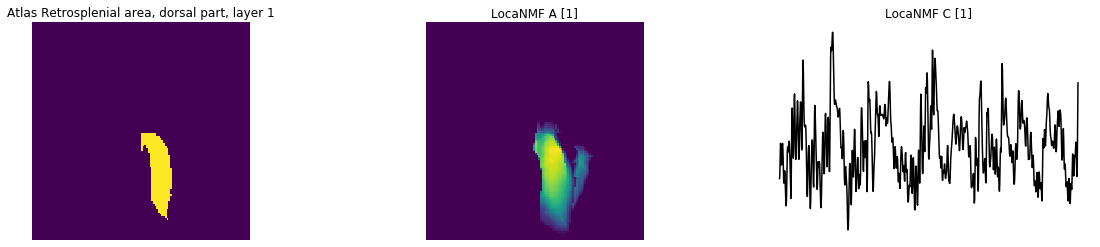

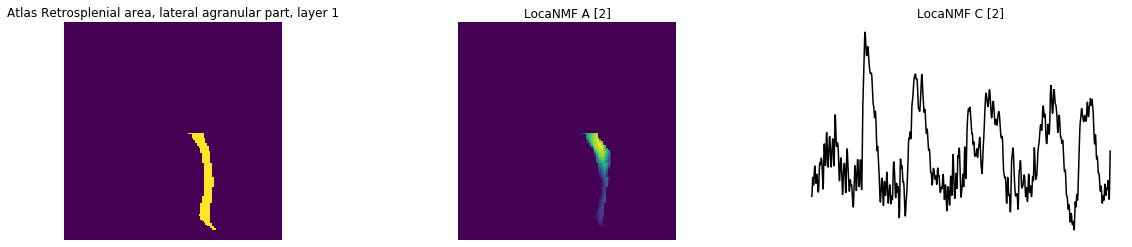

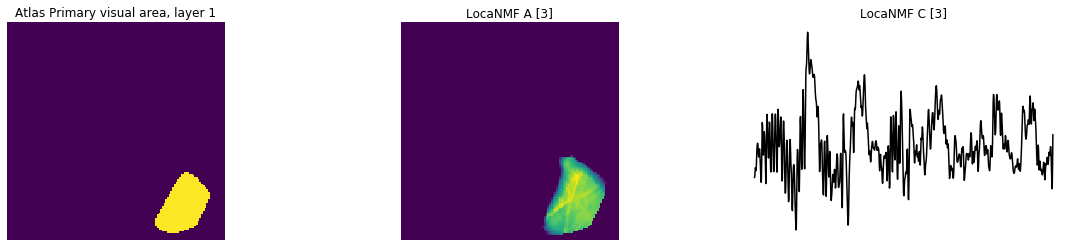

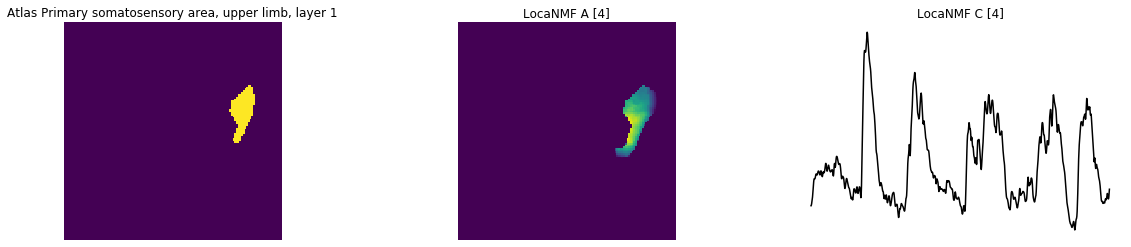

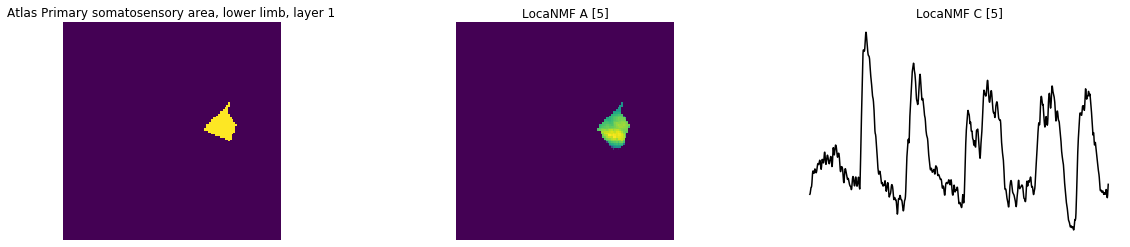

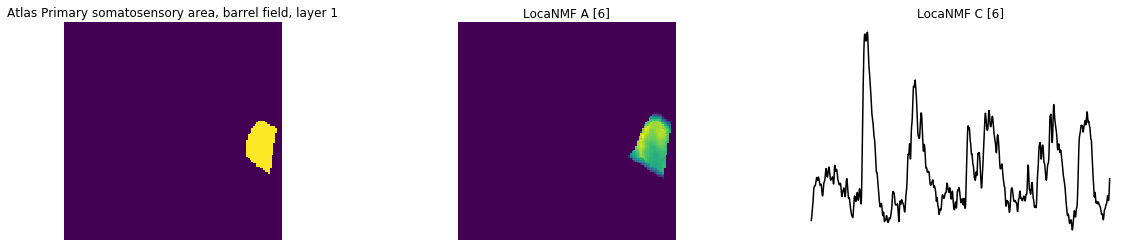

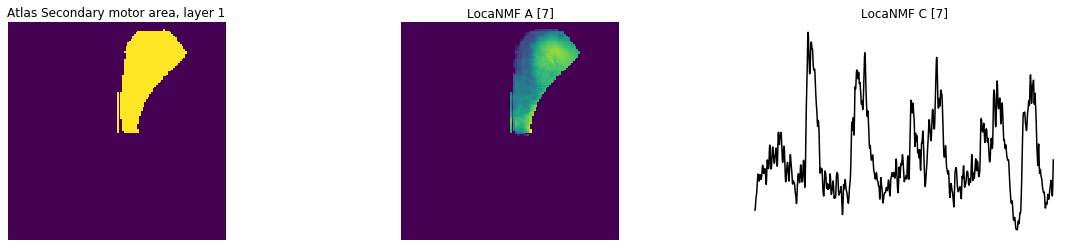

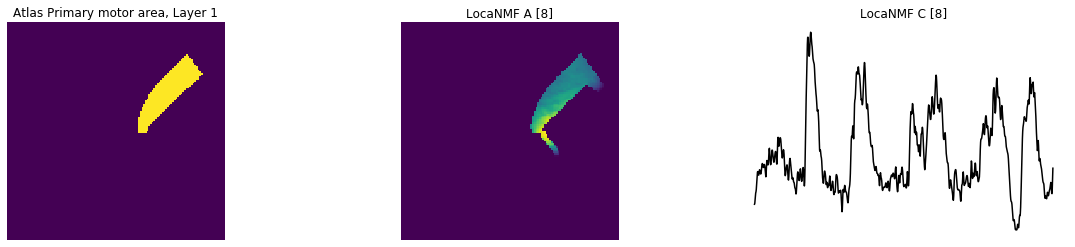

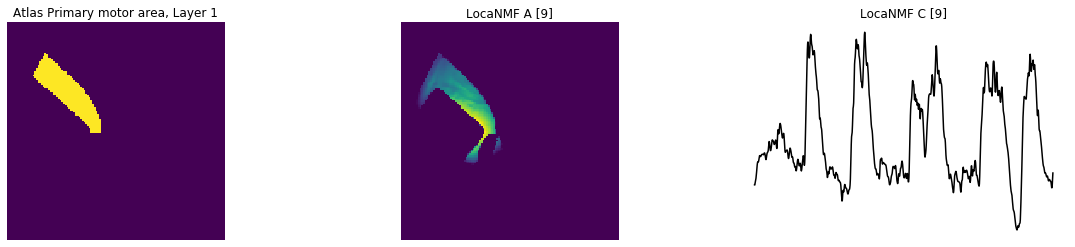

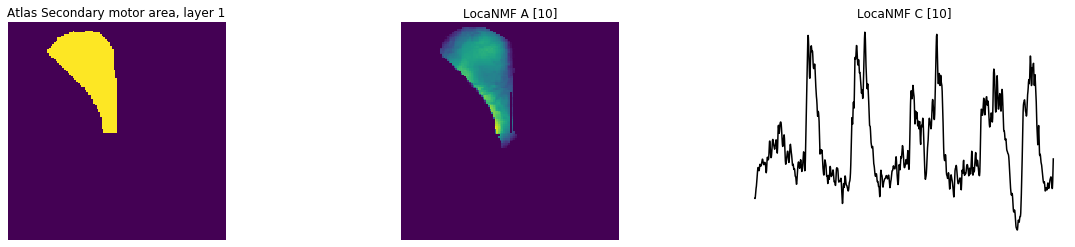

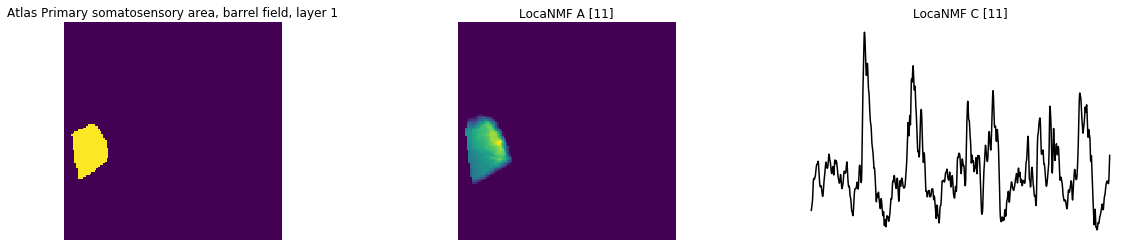

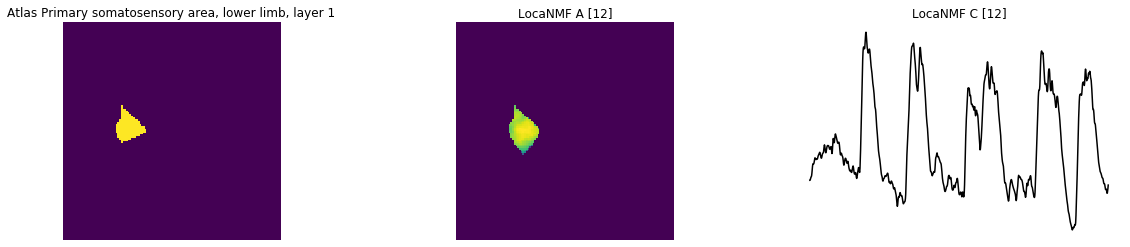

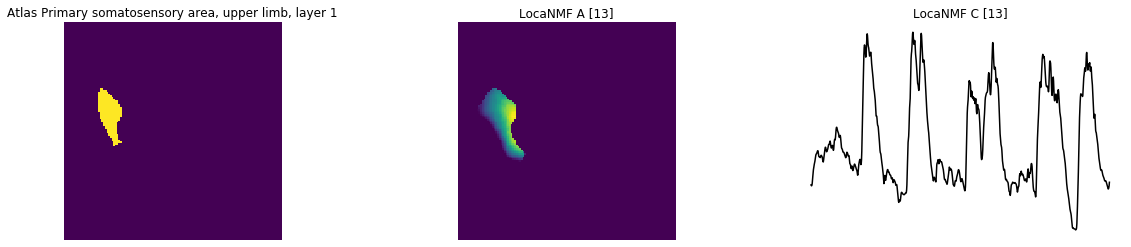

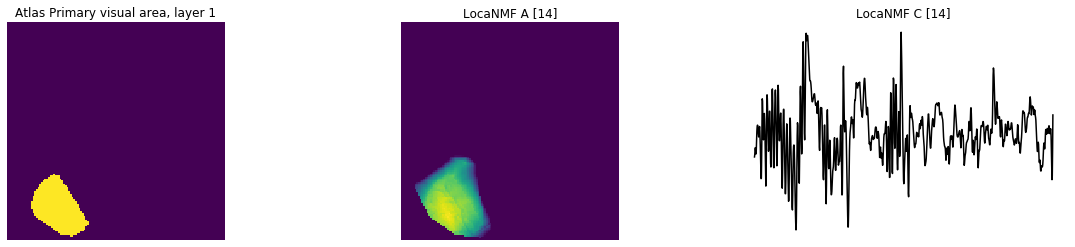

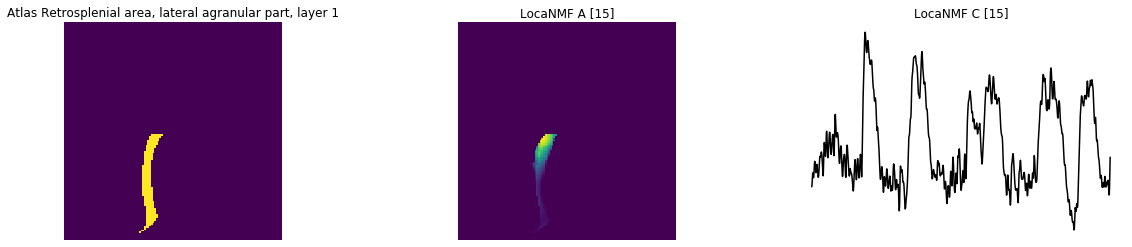

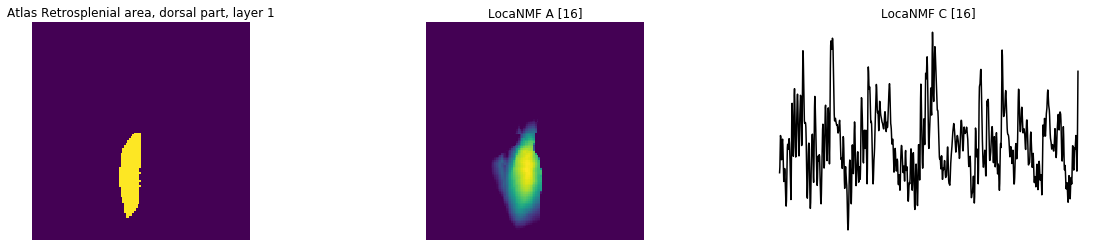

In [65]:
# Plotting all the regions' components
for i,area in enumerate(areas):
    try:
        fig=plt.figure(figsize=(20,4))
        ax1 = fig.add_subplot(1,3,1)
        plotmap_area = np.zeros((atlas.shape));
        plotmap_area.fill(np.nan);
        plotmap_area[brainmask] = atlas[brainmask]==area
        ax1.imshow(plotmap_area);
        ax1.set_title('Atlas '+areanames_area[i])
        ax1.axis('off')

        ax2 = fig.add_subplot(1,3,2)
        ax2.imshow(A_reshape[:,:,i])
        ax2.set_title('LocaNMF A [%s]'%(i+1))
        ax2.axis('off')

        ax3 = fig.add_subplot(1,3,3)
        ax3.plot(C[i,:min(1000,C.shape[1])],'k')
        if simulation:
            ax3.plot(V[np.where(area==trueareas)[0][0],:min(1000,V.shape[1])],'r');
            if i==0: ax3.legend(('LocaNMF','True'))
        ax3.set_title('LocaNMF C [%s]'%(i+1))
        ax3.axis('off')
        plt.show()
    except:
        pass


In [66]:
# Calculate Canonical Correlations between components in each pair of regions
corrmat=np.zeros((len(areainds),len(areainds)))
skipinds=[]
for i,area_i in enumerate(areainds):
    for j,area_j in enumerate(areainds):
        if i==0 and area_j not in areas:
            skipinds.append(j)
        C_i=C[np.where(areas==area_i)[0],:].T
        C_j=C[np.where(areas==area_j)[0],:].T
        if i not in skipinds and j not in skipinds:
            cca=CCA(n_components=1)
            cca.fit(C_i,C_j)
            C_i_cca,C_j_cca=cca.transform(C_i,C_j)
            try: C_i_cca=C_i_cca[:,0]
            except: pass
            try: C_j_cca=C_j_cca[:,0]
            except: pass               
            corrmat[i,j]=np.corrcoef(C_i_cca,C_j_cca)[0,1]
corrmat=np.delete(corrmat,skipinds,axis=0); 
corrmat=np.delete(corrmat,skipinds,axis=1);
corr_areanames=np.delete(areanames_all,skipinds)

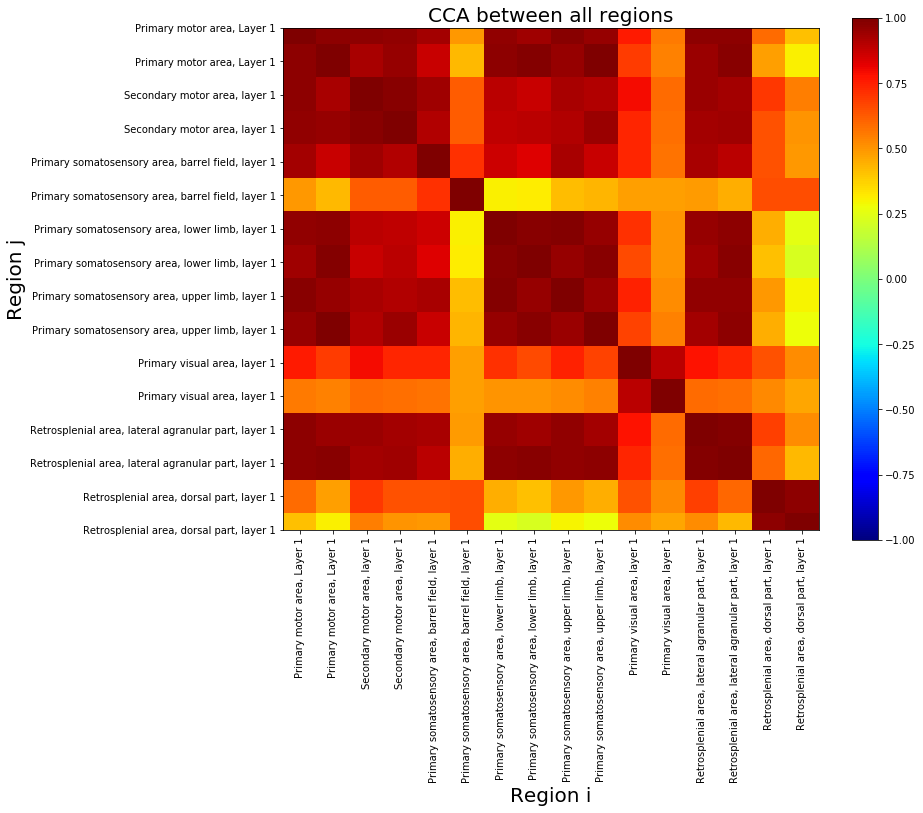

In [67]:
# Plot correlations
fig=plt.figure(figsize=(12,12))
plt.imshow(corrmat,cmap=plt.cm.get_cmap('jet')); plt.clim(-1,1); plt.colorbar(shrink=0.8)
plt.get_cmap('jet')
plt.xticks(ticks=np.arange(len(areainds)-len(skipinds)),labels=corr_areanames,rotation=90); 
plt.yticks(ticks=np.arange(len(areainds)-len(skipinds)),labels=corr_areanames); 
plt.title('CCA between all regions',fontsize=20)
plt.xlabel('Region i',fontsize=20)
plt.ylabel('Region j',fontsize=20)
plt.show()

In [68]:
# Save visualized components and correlations
# print('Saving postprocessing results!')
# postprocess.plot_components(A_reshape,C,areas,atlas,areanames,data_folder)
# postprocess.plot_correlations(A_reshape,C,areas,atlas,areanames,data_folder)